In [ ]:
!pip install split-folders

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import random
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir ='/content/drive/MyDrive/Colab-Notebooks/Pistachio_Image_Dataset'

In [ ]:
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 2158 files [00:31, 68.18 files/s] 


In [ ]:
train_path = './output/train'
test_path = './output/test'
val_path = './output/val'

In [ ]:
img = mpimg.imread('./output/train/Kirmizi_Pistachio/kirmizi 62.jpg')
img1 = mpimg.imread('./output/train/Siirt_Pistachio/siirt 603.jpg')

In [ ]:
img.shape, img1.shape

((600, 600, 3), (600, 600, 3))

In [ ]:
img_size = 512
batch = 32

In [ ]:
labels = []
for i in os.listdir(train_path):
    labels+=[i]

In [ ]:
labels

['Siirt_Pistachio', 'Kirmizi_Pistachio']

In [ ]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

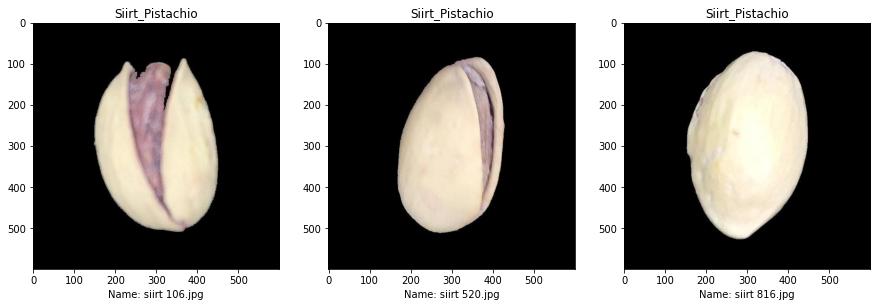

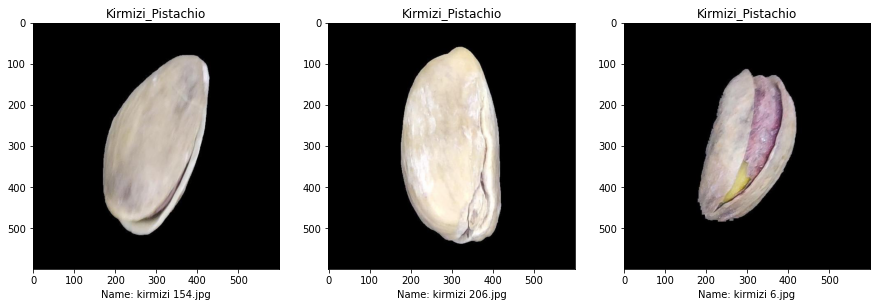

In [ ]:
for label in labels:
    load_random_imgs_from_folder(f"{data_dir}/{label}",label)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

val_generator = test_val_datagen.flow_from_directory(directory = val_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
)

Found 1725 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [ ]:
data_train = image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)
data_test = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)

Found 2158 files belonging to 2 classes.
Using 1727 files for training.
Found 2158 files belonging to 2 classes.
Using 431 files for validation.


In [ ]:
train_data_small = data_train.take(5)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

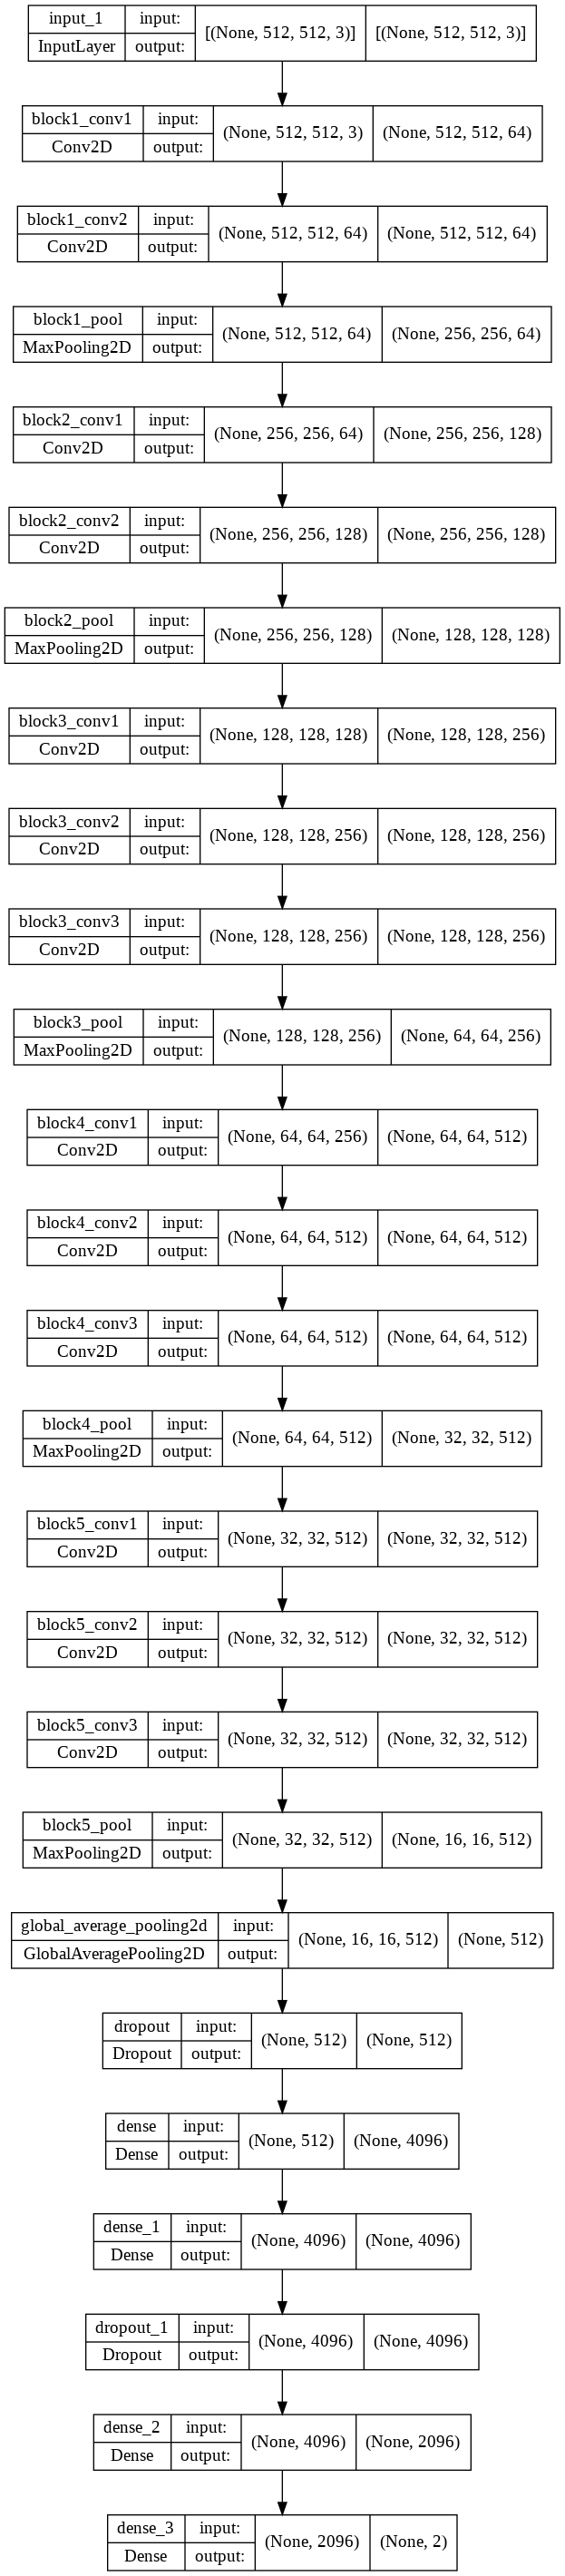

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [ ]:
opt = Adam(learning_rate=0.005)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [ ]:
#history=model.fit(data_train,
                  #epochs=50,
                  #validation_data=data_test,
                  #validation_steps=int(0.1 * len(data_test)),
                  #verbose=1,
                  #callbacks=callbacks)

Epoch 1/50
54/54 [==============================] - 4653s 86s/step - loss: 1.8326 - accuracy: 0.7620 - val_loss: 0.1106 - val_accuracy: 0.9375
Epoch 2/50
54/54 [==============================] - 4634s 86s/step - loss: 0.2455 - accuracy: 0.9021 - val_loss: 0.1633 - val_accuracy: 0.9062
Epoch 3/50
54/54 [==============================] - 4634s 86s/step - loss: 0.2980 - accuracy: 0.9033 - val_loss: 0.1328 - val_accuracy: 0.9688
Epoch 4/50
 5/54 [=>............................] - ETA: 1:08:57 - loss: 0.1771 - accuracy: 0.9312